# Проект: Статистический анализ данных

#### Оглавление
[1. Загрузка данных](#1)  
[2. Предобработка данных](#2)  
[3. Исследовательский анализ данных](#3)  
[4. Объединение данных](#4)  
[5. Подсчет выручки](#5)  
[6. Проверка гипотез](#6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.1. Равенство двух средних](#6.1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.2. Равенство среднего числу](#6.2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.3. Гипотеза о выручке](#6.3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.4. Ситауация](#6.4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[6.5. Общие выводы](#6.5)  
[7. Распределения](#7)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.1. Минимальное количество промокодов](#7.1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[7.2. Вероятность открытия уведомлений](#7.2)  
[8. Выводы](#8)  

В проекте используются данные сервиса аренды самокатов GoFast: данные содержат информацию о некоторых пользователях из нескольких городов, а также об их поездках, всего — 3 датасета

Сервисом GoFast можно пользоваться:
1. Без подписки:
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта — 50 рублей
2. С подпиской Ultra:
    * абонентская плата — 199 руб / месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

**Описание данных**

1. Пользователи `users`:

| Название столбца | Описание данных |
|------------------|-----------------|
|`user_id` | уникальный идентификатор пользователя |
|`name` | имя пользователя
|`age` | возраст
|`city` | город
|`subscription_type` | тип подписки (free, ultra)


2. Поездки `rides`:

| Название столбца | Описание данных |
|------------------|-----------------|
|`user_id` | уникальный идентификатор пользователя |
|`distance` | расстояние в текущей сессии (м)
|`duration` | продолжительность сессии (мин)
|`date` | дата совершения поездки


3. Подписки `subsc`:

| Название столбца | Описание данных |
|------------------|-----------------|
|`subscription_type` | тип подписки |
|`minute_price` | стоимость одной минуты поездки по данной подписке
|`start_ride_price` | стоимость начала поездки
|`subscription_fee` | стоимость ежемесячного платежа

## 1. Загрузка данных
<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
plt.style.use('https://drive.google.com/uc?id=1DCSnbxTAUIHzGN7XAy_yS7bTOK5Uc2FX&export=download')
%config InlineBackend.figure_format = 'retina'

Получим необходимые наборы данных и сохраним их как `users`, `rides` и `subscr`

In [2]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
subsc = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [3]:
def get_inf(df):
    '''
    Принимает датафрейм и возвращает
    - первые 5 строк
    - основную информацию о датасете
    - описательные статистики
    - число пропусков по столбцам
    '''
    display(df.head())
    display(df.info())
    display(df.describe())
    print(f'Число пропусков: \n{df.isna().sum()}\n')

In [4]:
# Информация о пользователях
get_inf(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Число пропусков: 
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64



In [5]:
# Информация о поездках
get_inf(rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Число пропусков: 
user_id     0
distance    0
duration    0
date        0
dtype: int64



In [6]:
# информация о подписках
get_inf(subsc)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


Число пропусков: 
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64



**Выводы:**
1. Датасет с информацией о пользователях `users` включает 1565 наблюдений, пропущенных знаяений нет.
2. Датасет с информацией о поездках `rides` включает 18068 наблюдений, пропущенных значений нет:
    * среднее расстояние поездки — 3 км;
    * средняя длительность поездки — 17.8 мин;
3. Датасет с информацией о подписках `subsc` включает 2 наблюдения — информацию о бесплатной подписке и о платной подписке Ultra.

## 2. Предобработка данных
<a class="anchor" id="2"></a>

Приведем столбец `date` датафрейма `rides` к типу данных `datetime` pandas:

In [7]:
# Изменяем тип данных
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

# Проверяем, что получилось
display(rides.head())
print(f'Тип данных после изменения: {rides.date.dtype}')

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Тип данных после изменения: datetime64[ns]


В датафрейме `rides` оздадим новый столбец с номером месяца:

In [8]:
# Добавляем столбец
rides['month'] = pd.DatetimeIndex(rides['date']).month

# Проверяем, что получилось
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим, данные за какой период у нас имеются:

In [9]:
print(f'Данные за период с {rides.date.min()} по {rides.date.max()}')

Данные за период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


Данные предоставлены за один год — с 1 января по 30 декабря 2021 года, то есть при группировке по месяцам ошибок не будет

В Шаге 1 было показано, что в датафреймах нет пропущенных значений. Произведем работу по удалению дубликатов:

In [10]:
# Проверяем наличие дубликатов
print(f'В датасете users дубликатов: {users.duplicated().sum()}')
print(f'В датасете rides дубликатов: {rides.duplicated().sum()}\n')

В датасете users дубликатов: 31
В датасете rides дубликатов: 0



In [11]:
# Удаляем явные дубликаты из датасета users
users = users.drop_duplicates().reset_index(drop=True)

# Проверяем, что получилось
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB
None


Проверим дафафрейм `users` на наличие неявных дуликатов:

In [12]:
# Уникальные значения столбца city
users.city.unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [13]:
# Уникальные значения столбца subscription_type
users.subscription_type.unique()

array(['ultra', 'free'], dtype=object)

Неявных дубликатов не обнаружено

**Выводы:**
1. Столбец `date` датафрейма `rides` приведен к типу данных `datetime` pandas;
2. В датафрейм `rides` добавлен столбец `month` с номером месяца поездки;
3. Пропущенных значений в датафреймах нет;
4. В датафрейме `users` изавились от 31 явных дубликатов; неявных дубликатов в датасетах не обнаружено.

## 3. Исследовательский анализ данных 
<a class="anchor" id="3"></a>

Опишем и визуализируем общую информацию о пользователях и поездках:

1. Частота встречающихся городов

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64



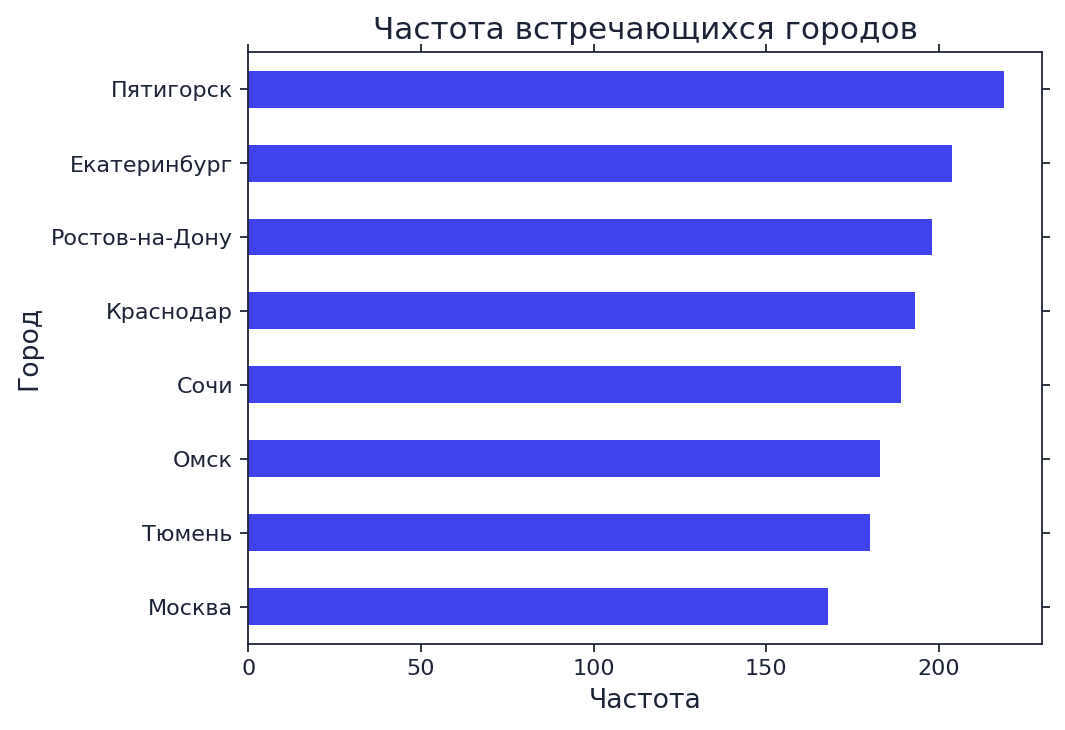

In [14]:
# Получаем значения
print(users.city.value_counts())
print()

# Строим столбчатую диаграмму
users.city.value_counts(ascending=True).plot(kind='barh', xlabel='Частота', ylabel='Город')
plt.title('Частота встречающихся городов')
plt.show()

* В датасете представлены 8 городов: Пятигорск, Екатеринбург, Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва;
* Чаще всего встречается Пятигорск — число наблюдений 219;
* Реже всего встречается Москва — число наблюдений 168;
* Разница между максимальной и минимальной частотой — 51, что составляет 23.3% от частоты появления Пятигорска

2. Соотношение числа пользователей с подпиской и без подписки

subscription_type
free     835
ultra    699
Name: count, dtype: int64



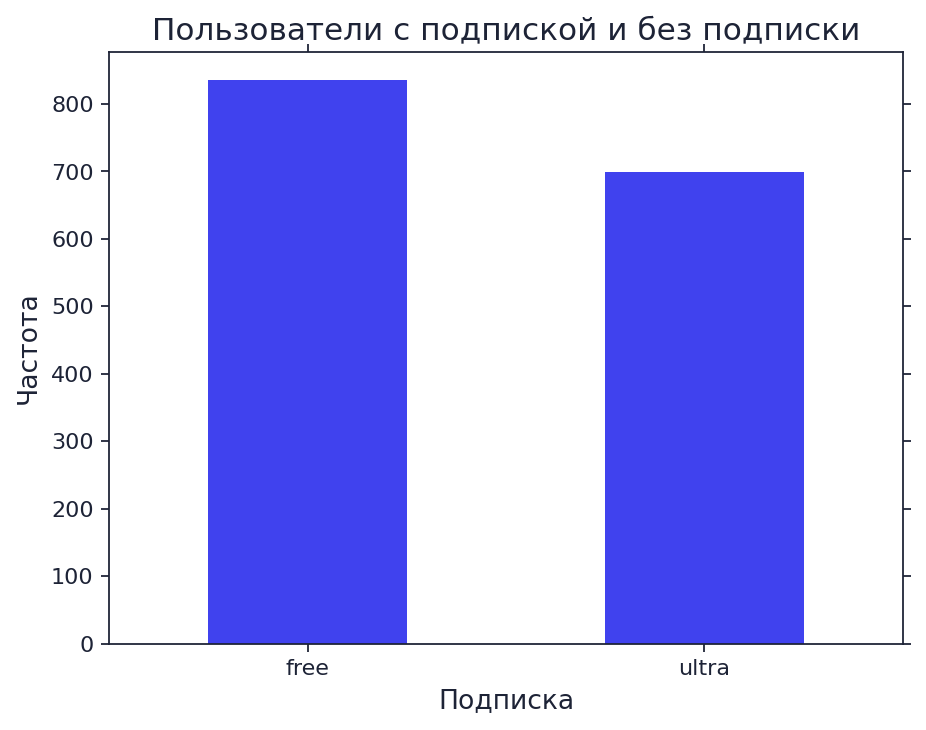

In [15]:
# Получаем значения
print(users.subscription_type.value_counts())
print()

# Строим столбчатую диаграмму
users.subscription_type.value_counts().plot(kind='bar', xlabel='Подписка', 
                                            ylabel='Частота')
plt.title('Пользователи с подпиской и без подписки')
plt.xticks(rotation=0)
plt.show()

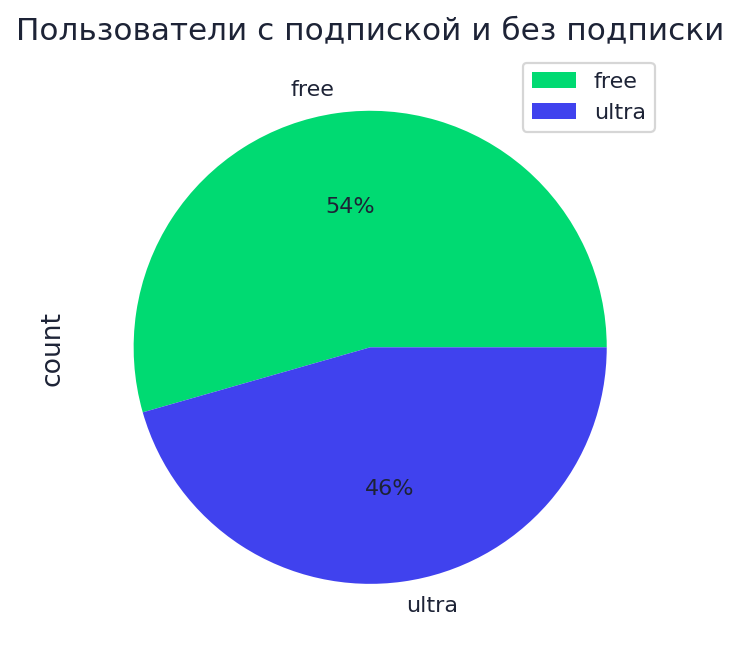

In [16]:
# Строим круговую диаграмму
users.subscription_type.value_counts().plot(kind='pie', y='Число пользователей', autopct='%1.0f%%', colors=['#00DA72', '#4042EE'])
plt.title('Пользователи с подпиской и без подписки')
plt.legend()
plt.show()

* Число пользователей без подписки — 835 (54.4% выборки);
* Число пользователей с подпиской — 699 (45.6% выборки);
* Число пользователей с подпиской на 16.3% меньше числа пользователей без подписки.

3. Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64



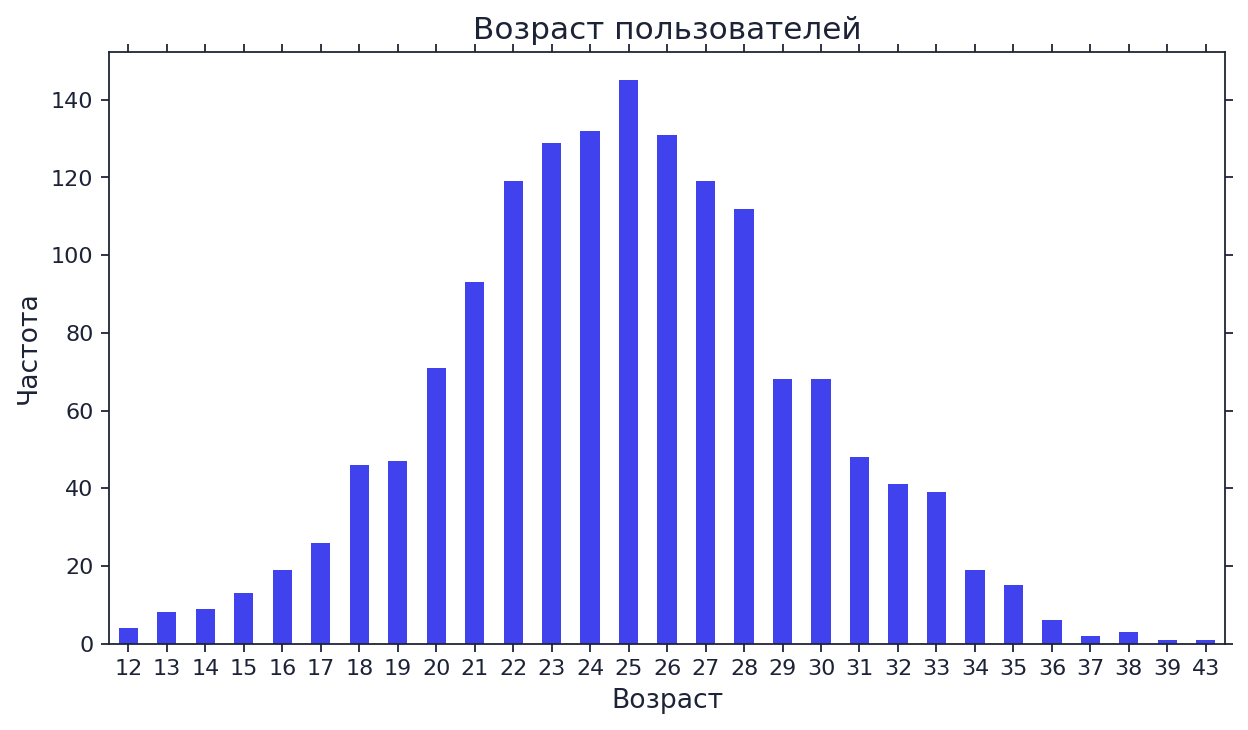

In [17]:
# Получаем статистику
print(users.age.describe())
print()

# Строим столбчатую диаграмму
users.age.value_counts().sort_index().plot(kind='bar',
                                           xlabel='Возраст',
                                           ylabel='Частота',
                                           figsize=(9, 4.8))
plt.title('Возраст пользователей')
plt.xticks(rotation=0)
plt.show()

* Возраст пользователей выборки имеет распределение, близкое к нормальному, со средним $\bar{x}=24.9$ и стандартным отклонением $\text{sd}=4.57$;
* Минимальный представленный возраст — 12 лет, максимальный — 43 года;
* Медианное значение возраста пользователей — 25 лет: это значение встречается около 145 раз.

4. Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64



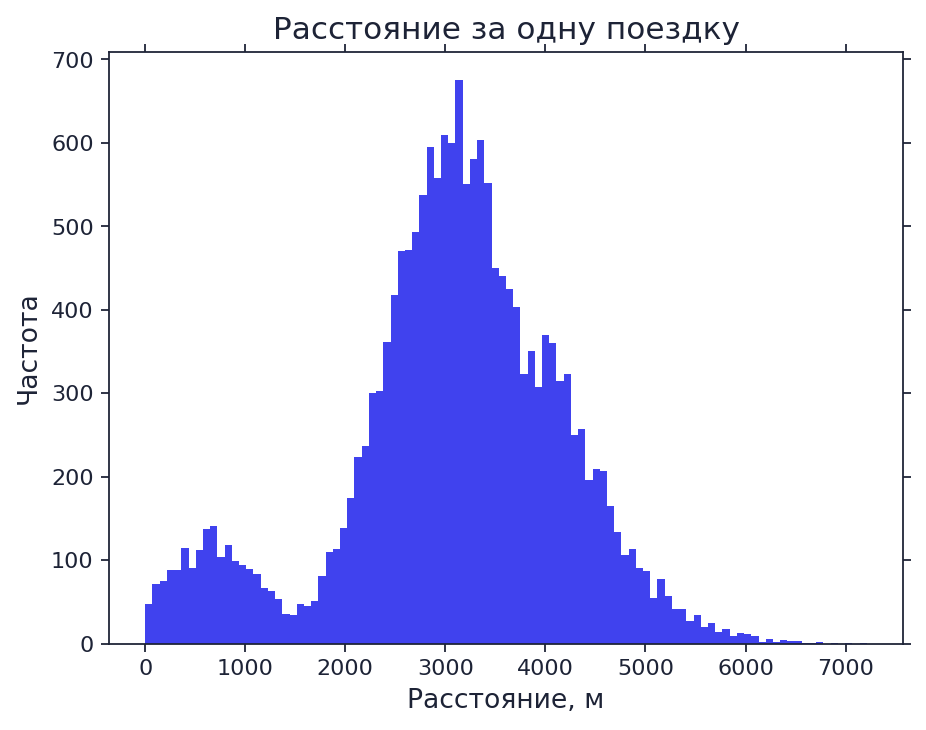

In [18]:
# Получаем статистику
print(rides.distance.describe())
print()

# Строим гистограмму
plt.hist(rides.distance, bins=100)
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.title('Расстояние за одну поездку')
plt.show()

In [19]:
print(f'Поездок <1500 м: {len(rides[rides.distance<1500])} шт.,  {round(len(rides[rides.distance<1500]) / len(rides) * 100, 2)}%')
print(f'Поездок >1500 м: {len(rides[rides.distance>1500])} шт., {round(len(rides[rides.distance>1500]) / len(rides) * 100, 2)}%')

Поездок <1500 м: 1796 шт.,  9.94%
Поездок >1500 м: 16272 шт., 90.06%


* Полученное распределение — бимодальное: с первой модой в районе 800 м и второй модой в районе 3 200 м;
* Данные можно разделить на две группы по расстоянию, преодолеваемому пользователю за одну поездку, на две группы:
   - короткие: 0 ... 1 500 м (около 10% всех поездок);
   - длинные: более 1 500 м (около 90% всех поездок);
* Распределение каждой из групп близко к нормальному;
* Коротких поездок, по сравнению с длинными, меньше на 88.9%. Вероятно, их наличие связано с желанием новых пользователей "попробовать" покататься.

5. Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64



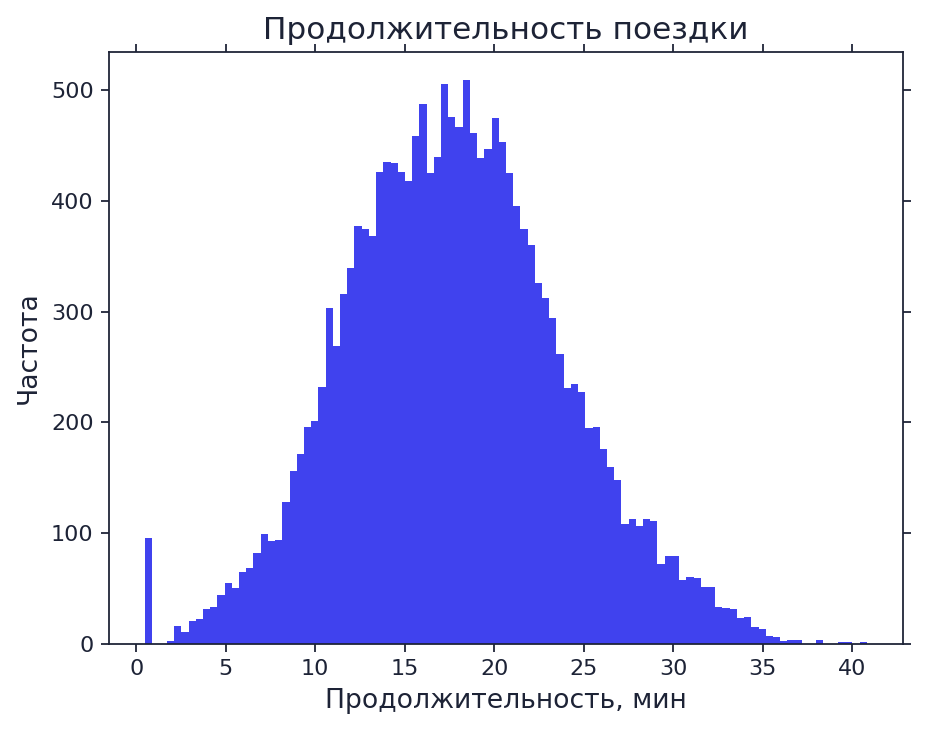

In [20]:
# Получаем статистику
print(rides.duration.describe())
print()

# Строим гистограмму
plt.hist(rides.duration, bins=100)
plt.xlabel('Продолжительность, мин')
plt.ylabel('Частота')
plt.title('Продолжительность поездки')
plt.show()

In [21]:
print(f'Число поездок продолжительностью 30 сек: {len(rides[rides.duration == 0.5])}')

Число поездок продолжительностью 30 сек: 95


Посмотрим на расстояние этих поездок:

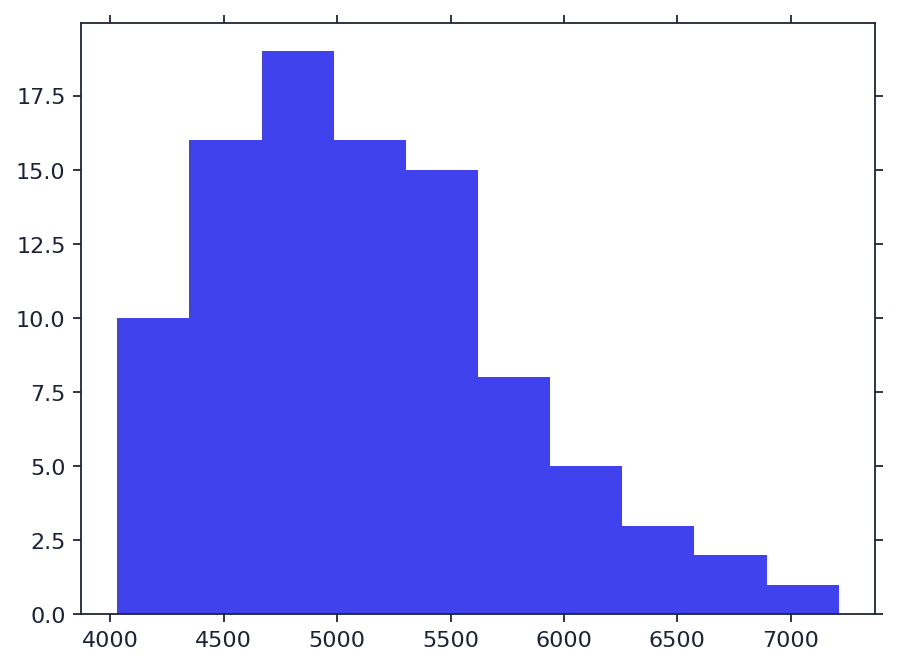

In [22]:
rides[rides.duration == 0.5].distance.hist(grid=False, bins=10)
plt.show()

Расстояния для поездок с длительностью 30 сек превышают 4 000 м, возможно, их наличие связано с ошибками в системе. Удалим эти аномальные значения:

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64



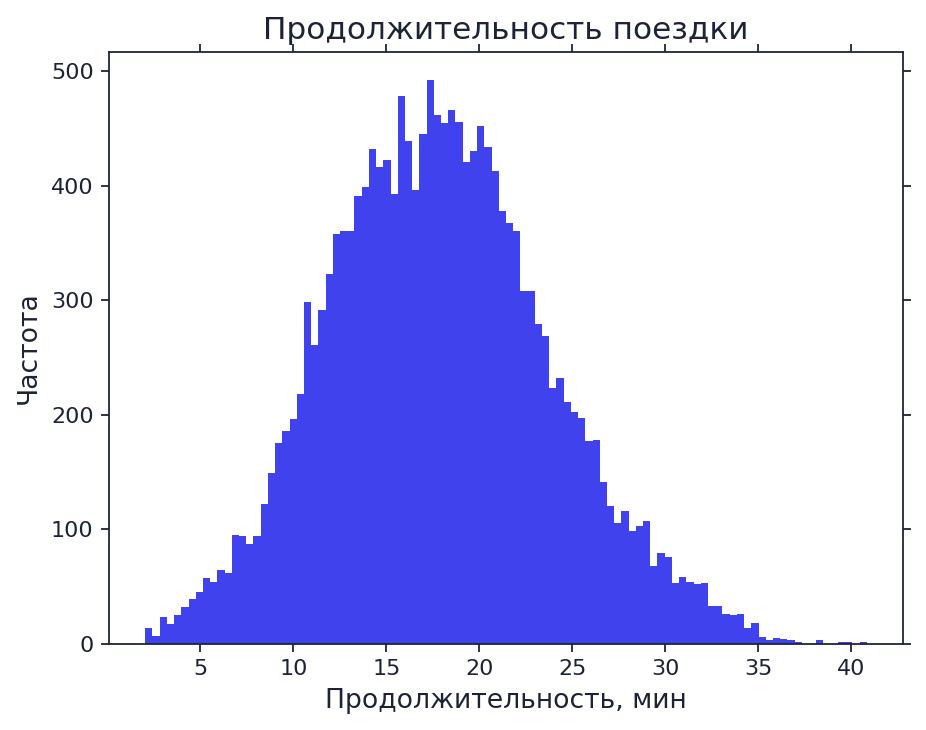

In [23]:
# Удаляем аномалии
rides = rides[rides.duration > 0.5]

# Смотрим, что получилось
print(rides.duration.describe())
print()

plt.hist(rides.duration, bins=100)
plt.xlabel('Продолжительность, мин')
plt.ylabel('Частота')
plt.title('Продолжительность поездки')
plt.show()

* Полученное распределение близко к нормальному со средним $\bar{x}=17.9$ и стандартным отклонением $\text{sd}=5.98$;
* Минимальное значение продолжительности поездки в выборке — 2 минуты, максимальное — около 41 минуты;
* 95 раз встречающееся значение 30 сек,скорее всего, вызвано ошибкой, поэтому эти наблюдения были удалены как аномальные.

**Выводы:**
1. В данных представлены 8 городов; наибольшее число поездок — в Пятигорске (219), наименьшее — в Москве (168, т. е. на 23.3% меньше);
2. Число пользователей без подписки — 835 (54.4% выборки); число пользователей с подпиской — 699 (45.6% выборки, т. е. на 16.3% меньше);
3. Возраст пользователей варьируется от 12 до 43 лет и имеет распределение, близкое к нормальному, со средним $\bar{x}^{\text{age}}=24.9$ и стандартным отклонением $\text{sd}^{\text{age}}=4.57$;
4. Расстояние, которое пользователь преодолел за одну поездку, варьируется от 0.9 до 7 211 м и является бимодальным, данные можно разделить на две группы, распределение в каждой из которых близко к нормальному:
      * короткие поездки: 0 ... 1 500 м с модой 800 м (около 10% всех поездок)
        
      * длинные поездки: более 1500 м с модой 3 200 м (около 90% всех поездок)
   
   Вероятно, наличие коротких поездок связано с тем, что новым пользователям интересно "попробовать" покататься;
6. Продолжительность поездок варьируется от 30 сек до 40.8 мин и имеет распределение, близкое к нормальному, со средним $\bar{x}^{d}=17.9$ и стандартным отклонением $\text{sd}^{d}=5.98$;
   
   Аномалия из 95 поездок длительностью 30 сек, вероятно, возникли из-за ошибки и поэтому были удалены из датасета `rides`.

## 4. Объединение данных 
<a class="anchor" id="4"></a>

Объединим данные о пользователях, поездках и подписках в единый датафрейм `df`:

In [24]:
# Объединяем датафреймы
df = rides.merge(users, on='user_id', how='left')
df = df.merge(subsc, on='subscription_type', how='left')

# проверяем, что получилось
display(df.head())
df.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Число строк полученной таблицы (17 973) совпадает с числом строк в датафрейме `rides` после удаления аномалий.

Создадим еще два датафрейма:
1. `df_free`: с пользователями без подписки
2. `df_ultra`: с пользователями с подпиской

In [25]:
# Создаем новые датафреймы
df_free = df[df.subscription_type == 'free']
df_ultra = df[df.subscription_type == 'ultra']

# проверяем, что получилось
print('Пользователи без подписки df_free:')
display(df_free.head())
print(df_free.info())
print('\nПользователи с подпиской df_ultra:')
display(df_ultra.head())
print(df_ultra.info())

Пользователи без подписки df_free:


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


<class 'pandas.core.frame.DataFrame'>
Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int32         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB
None

Пользователи с подпиской d

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int32         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB
None


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий:

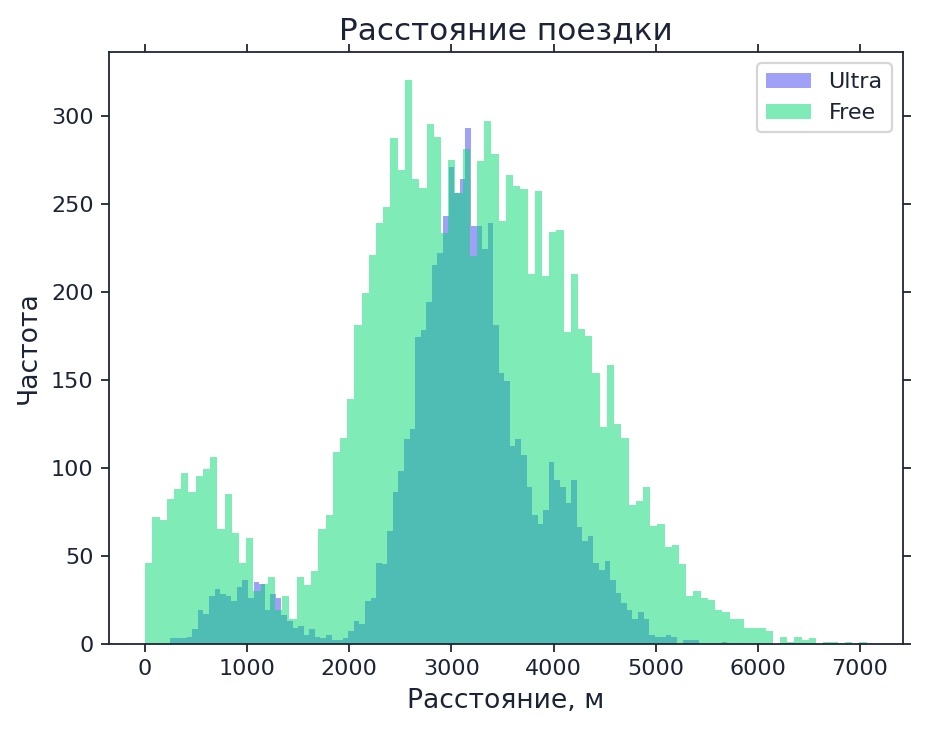

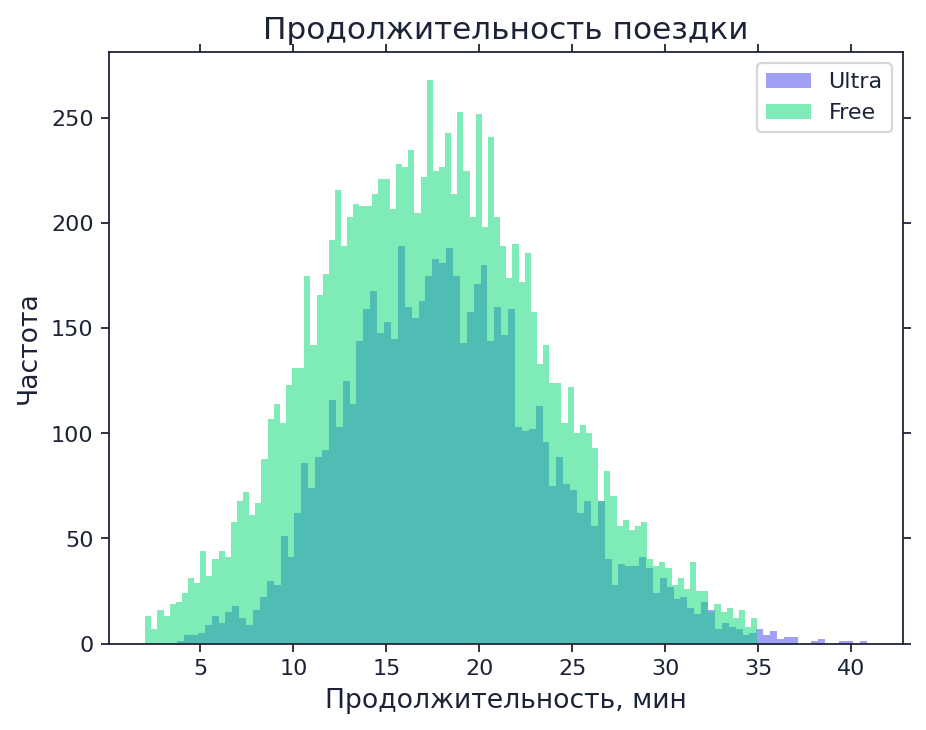

In [26]:
# Расстояние поездки
plt.hist(df_ultra.distance, bins=100, alpha=0.5, label='Ultra')
plt.hist(df_free.distance, bins=100, alpha=0.5, label='Free')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.title('Расстояние поездки')
plt.legend()
plt.show()

# Время поездки
plt.hist(df_ultra.duration, bins=100, alpha=0.5, label='Ultra')
plt.hist(df_free.duration, bins=100, alpha=0.5, label='Free')
plt.xlabel('Продолжительность, мин')
plt.ylabel('Частота')
plt.title('Продолжительность поездки')
plt.legend()
plt.show()

In [27]:
# Получим статистики
print('Пользователи с подпиской:')
display(df_ultra[['distance', 'duration']].describe())
print('\nПользватели без подписки:')
display(df_free[['distance', 'duration']].describe())

Пользователи с подпиской:


,distance,duration
count,6500.000000,6500.000000
mean,3115.445388,18.541985
std,836.895330,5.572048
min,244.210438,3.760353
25%,2785.444017,14.524654
50%,3148.637229,18.178153
75%,3560.574425,21.884129
max,5699.769662,40.823963



Пользватели без подписки:


,distance,duration
count,11473.000000,11473.000000
mean,3028.374239,17.530771
std,1235.541051,6.162609
min,0.855683,2.035632
25%,2360.878149,13.085688
50%,3102.083025,17.383807
75%,3883.979311,21.638038
max,7066.003772,34.948498


**Выводы:**
1. Число поездок среди пользователей с подпиской (6500 поездок) на 43.8% меньше, чем количество поездок пользователей без подписки (11 568 поездок): по этой причине гистограммы построенные по данным `df_free` оказались "выше";
3. Расстояние поездки:
    * Распределения для обеих групп пользователей оказались бимодальными, однако моды как для коротких, так и для длинных поездок больше для пользователей с подпиской;
    * Выборки отличаются средним и медианой: для пользователей с подпиской $\bar{x}^d_1=3 \, 115, \ \text{me}^d_1=3 \, 148$, а для пользователей без подписки эти значения меньше и составляют $\bar{x}^d_0=3 \, 045, \ \text{me}^d_0=3 \, 115$;
    * Данные для пользователей с подпиской менее вариативны (со стандартным отклонением $\text{sd}^d_1=836.9$ и 1-м и 3-м квартилями 2785.5 и 3560.6), чем данные для пользователей без подписки (со стандартным отклонением $\text{sd}^d_0=1246.2$ и 1-м и 3-м квартилями 2366.6 и 3905.7);
4. Продолжительность поездки:
    * Распределения для обеих групп пользователей близки к нормальному, однако для пользователей с подпиской (со средним и медианой $\bar{x}^t_1=18.5, \ \text{me}^t_1=18.2$) оно незначительно сдвинут вправо по сравнению с распределением для пользователей без подписки (со средним и медианой $\bar{x}^t_0=17.4, \ \text{me}^t_0=17.3$);
    * В целом, можно сказать, что длительность поездки для пользователей с подпиской больше, чем для пользователей без подписки; статистическую значимость этого различия еще предстоит проверить.

## 5. Подсчет выручки
<a class="anchor" id="5"></a>

Создадим датафрейм `df_agg` с аггрегированными данными о поездках: для каждого пользователя за каждый месяц найдем:
   * количество поездок `count`;
   * суммарное расстояние `distance_sum`;
   * суммарное время `duration_sum`;
   * также добавим тип подписки `subscription_type`:

In [28]:
# Округлим все значения в столбце duration в большую сторону
df['duration'] = np.ceil(df['duration'])
df.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26.0,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16.0,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7.0,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19.0,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27.0,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [29]:
# Создадаем аггрегированный датафрейм
df_agg = df.pivot_table(index=['user_id', 'month'],
                        aggfunc={'distance': ['sum', 'count'],
                                 'duration': 'sum',
                                 'subscription_type': 'first',
                                 'minute_price': 'first',
                                 'start_ride_price': 'first',
                                 'subscription_fee': 'first'})
df_agg = df_agg.reset_index()
df_agg.columns = ['user_id', 'month', 'count', 'distance_sum', 'duration_sum', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
df_agg

,user_id,month,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,2,7027.511294,42.0,6,0,199,ultra
1,1,4,1,754.159807,7.0,6,0,199,ultra
2,1,8,2,6723.470560,46.0,6,0,199,ultra
3,1,10,2,5809.911100,32.0,6,0,199,ultra
4,1,11,3,7003.499363,56.0,6,0,199,ultra
...,...,...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,8,50,0,free
11296,1534,8,2,7622.453034,48.0,8,50,0,free
11297,1534,9,1,4928.173852,23.0,8,50,0,free
11298,1534,11,4,13350.015305,78.0,8,50,0,free


В этот же датафрейм добавим столбец `revenue` с помесячной выручкой, которую принёс каждый пользователь:

In [30]:
# Добавим столбец revenue с помощью векторных операций со столбцами
df_agg['revenue'] = df_agg['start_ride_price'] * df_agg['count'] + df_agg['minute_price'] * df_agg['duration_sum'] + df_agg['subscription_fee']
df_agg.head()

,user_id,month,count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,2,7027.511294,42.0,6,0,199,ultra,451.0
1,1,4,1,754.159807,7.0,6,0,199,ultra,241.0
2,1,8,2,6723.470560,46.0,6,0,199,ultra,475.0
3,1,10,2,5809.911100,32.0,6,0,199,ultra,391.0
4,1,11,3,7003.499363,56.0,6,0,199,ultra,535.0


Оценим распределения для ежемесячной выручки для пользователей без подписки и с подпиской:

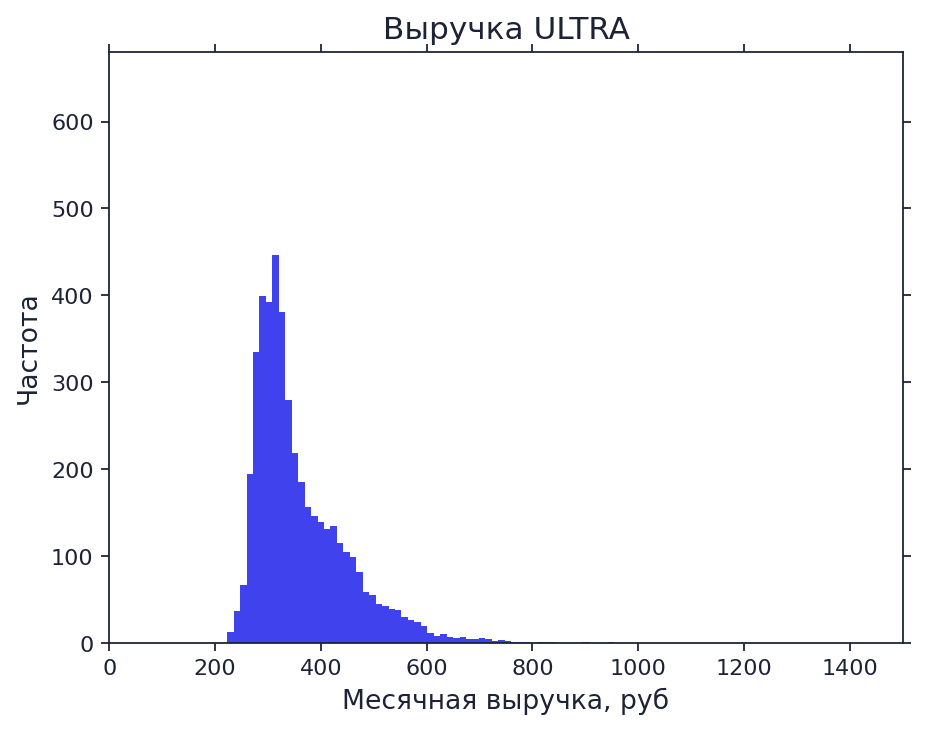

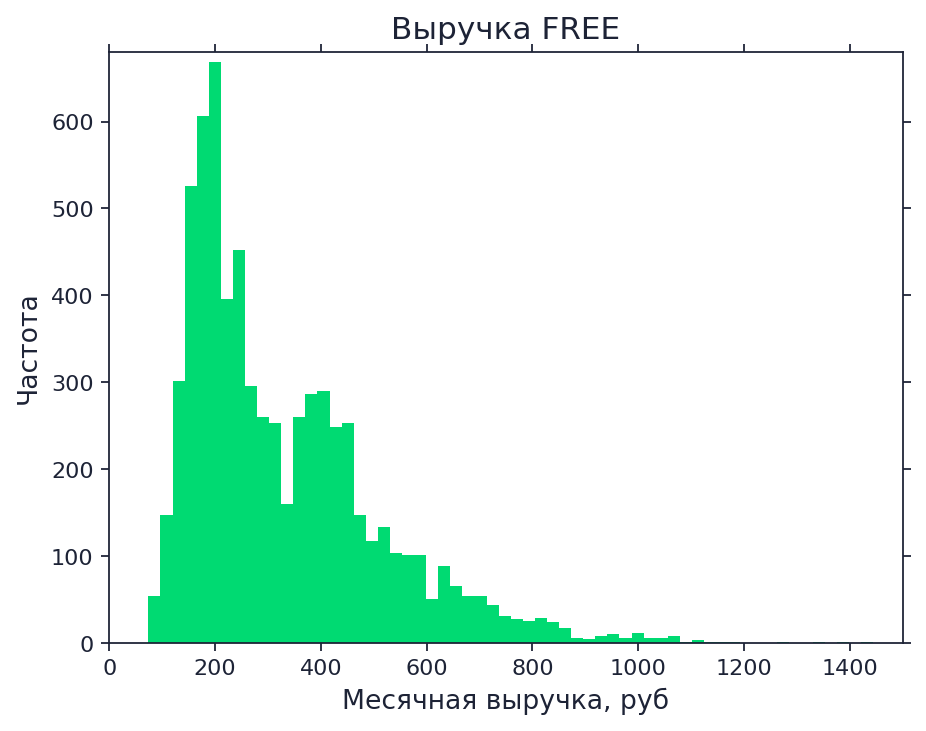


Для пользователей с подпиской:

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64

Для пользователей без подписки:



count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

In [31]:
# Для пользователей с подпиской
plt.hist(df_agg[df_agg.subscription_type == 'ultra'].revenue, bins=60)
plt.xlim(0, 1500)
plt.ylim(0, 680)
plt.xlabel('Месячная выручка, руб')
plt.ylabel('Частота')
plt.title('Выручка ULTRA')
plt.show()

# Для пользователей без подпиской
plt.hist(df_agg[df_agg.subscription_type == 'free'].revenue,
         bins=60, color='#00DA72')
plt.xlim(0, 1500)
plt.ylim(0, 680)
plt.xlabel('Месячная выручка, руб')
plt.ylabel('Частота')
plt.title('Выручка FREE')
plt.show()

# Получим статистику
print('\nДля пользователей с подпиской:\n')
print(df_agg[df_agg.subscription_type == 'ultra'].revenue.describe())
print('\nДля пользователей без подписки:\n')
df_agg[df_agg.subscription_type == 'free'].revenue.describe()

**Выводы:**
На данном шаге был создан датафрейм `df_agg` с аггрегированными данными о поездках: для каждого пользователя в каждом месяце указаны:
* число поездок;
* суммарное расстояние;
* сумарное время;
* выручка, принесенная пользователем.

Кроме того, судя по распределениям месячной выручки от каждого пользователя, пользователи с подпиской (со средним и медианой $\bar{x}_1^\$=362.8, \ \text{me}_1^\$=337 $), в среднем, приносят компании на 10% больший доход, чем пользователи без подписки (со средним и медианой $\bar{x}_0^\$=328.6, \ \text{me}_0^\$=274 $).

## 6. Проверка гипотез 
<a class="anchor" id="6"></a>

### 6.1. Равенство двух средних 
<a class="anchor" id="6.1"></a>

Проверим, тратят ли пользователи с подпиской больше времени на поездки:

* $H_0$: $\mu_1^t \ = \ \mu_0^t$, т. е. средняя продолижтельность поездки для генеральной совокупности пользователей с подпиской равна средней продолжительности поездки для генеральной совокупности пользователей без подписки
* $H_1$: $\mu_1^t \ > \ \mu_0^t$, т. е. средняя продолижтельность поездки для генеральной совокупности пользователей с подпиской больше средней продолжительности поездки для генеральной совокупности пользователей без подписки

Будем применять t-тест для проверки правосторонней гипотезы о равенстве средних в двух генеральных совокупностях со значением уровня статистической значимости $\alpha=0.05$. Условия применения t-теста удовлетворены:
1. Две генеральные совокупности действительно независимы;
2. Число наблюдений в выборках более 30, поэтому можно утверждать, что распределение выборочных средних близко к нормальному (в соответствии с ЦПТ);
3. Гомогенность дисперсий: $\text{sd}_1^t=5.57, \ \text{sd}_0^t=6.32$, т. е. дисперсии действительно примерно равны

In [32]:
alpha = 0.05
result = st.ttest_ind(df_ultra.duration, df_free.duration,
                      alternative='greater')

print(f'p-value: {result.pvalue}')
if result.pvalue < alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value: 4.704468074453899e-28
Отклоняем нулевую гипотезу


**Вывод:** Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показаои, что средняя продолжительность поездки среди пользователей с подпиской больше, чем среди пользователей без подписки со значением p-value $1.28 \cdot 10^{-34}$

### 6.2. Равенство среднего числу 
<a class="anchor" id="6.2"></a>

Оптимальное с точки зрения износа самоката расстояние поездки $\mu=3130$ м. Проверим, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает этого значения:
* $H_0$: $\mu_1^d = 3130$, т. е. среднее значение длительности поездки для генеральной совокупности пользователей с подпиской равно 3 130 м
* $H_1$: $\mu_1^d > 3130$, т. е. среднее значение длительности поездки для генеральной совокупности пользователей с подпиской больше 3 130 м

Будем применять t-тест для проверки левосторонней гипотезы о равенстве среднего генеральной совокупности числу со значением уровня статистической значимости $\alpha=0.05$.

In [33]:
alpha = 0.05
result = st.ttest_1samp(df_ultra.distance, 3130,
                        alternative='greater')

print(f'p-value: {result.pvalue}')
if result.pvalue < alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отклонить нулевую гипотезу


**Вывод:** Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что действительно можно сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3 130 м.

### 6.3. Гипотеза о выручке 
<a class="anchor" id="6.3"></a>

Проверим гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки:
* $H_0$: $\mu_1^\$ \ = \ \mu_0^\$ $, т. е. средняя помесячная выручка от генеральной совокупности пользователей с подпиской $\bar{x}_1^t$ равна средней помесячной выручке от генеральной совокупности пользователей без подписки
* $H_1$: $\mu_1^\$ \ > \ \mu_0^\$ $

Будем применять t-тест для проверки правосторонней гипотезы о равенстве средних в двух генеральных совокупностях со значением уровня статистической значимости $\alpha=0.05$. Условия применения t-теста удовлетворены:
1. Две генеральные совокупности действительно независимы;
2. Число наблюдений в выборках более 30, поэтому можно утверждать, что распределение выборочных средних близко к нормальному (в соответствии с ЦПТ);
3. Гомогенность дисперсий: $\text{sd}_1^\$=88.3, \ \text{sd}_0^\$=183.9$, т. е. дисперсия для пользователей без подписки значительно превышает дисперсию для пользователей с подпиской; используем дополнительный аргумент `equal_var=False`

In [34]:
alpha = 0.05
result = st.ttest_ind(df_agg[df_agg.subscription_type == 'ultra'].revenue,
                      df_agg[df_agg.subscription_type == 'free'].revenue,
                      equal_var=False,
                      alternative='greater')

print(f'p-value: {result.pvalue}')
if result.pvalue < alpha:
    print('Отклоняем нулевую гипотезу')
else:
    print('Нет оснований отклонить нулевую гипотезу')

p-value: 2.4970242872858465e-38
Отклоняем нулевую гипотезу


**Вывод:** Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показаои, что средняя помесячная выруска от пользователей с подпиской больше, чем от пользователей без подписки со значением p-value $8.87 \cdot 10^{-40}$

### 6.4. Ситуация 
<a class="anchor" id="6.4"></a>

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном примере выборки, для которых необходимо проверить гипотезу, предсталвяеют собой выборки из одних и тех же пользователей до и после обновления: такие выборки являются зависимыми, поэтому к ним нельзя применить обычный t-тест `st.ttest_ind`; в данном случае необходимо использовать t-тест для зависимых выборок `st.ttest_rel`

### 6.5. Общие выводы 
<a class="anchor" id="6.5"></a>

1. Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что средняя продолжительность поездки среди пользователей с подпиской больше, чем среди пользователей без подписки со значением p-value $1.28 \cdot 10^{-34}$;
2. Несмотря на то, что выборочное среднее $\bar{x}_1^d=3045.5$ (средняя дальность поездки для пользователей с подпиской) меньше, чем 3 130, результаты левостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что это отклонение не является статистически значимым;
3. Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показаои, что средняя помесячная выруска от пользователей с подпиской больше, чем от пользователей без подписки со значением p-value $8.87 \cdot 10^{-40}$;
4. Если бы пришлось проверять статистическую гипотезу для двух выборок из одних и тех же пользователей до и после некоторого события, необходимо было бы применить t-тест для зависимых выборок `st.ttest_rel`.

## 7. Распределения 
<a class="anchor" id="7"></a>

### 7.1. Минимальное количество промокодов 
<a class="anchor" id="7.1"></a>

После бесплатного пробного периода подписку продлевают 10% пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы с вероятностью 0.95 как минимум 100 из клиентов продлят подписку.

По завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж: таким образом, в данном случае имеем дело с биномиальным распределением с заданным значением параметра $p=0.1$ — вероятность, что пользователь продлит подписку, и неизвестным значением параметра $n$.

Попробуем рассчитать значение $P(x>100) = 1 - F(100)$ для нескольких значений $n$ в диапазоне от 1 000 до 2 000 с шагом в 10, и построим линейный график с соответствующими значениями вероятности:

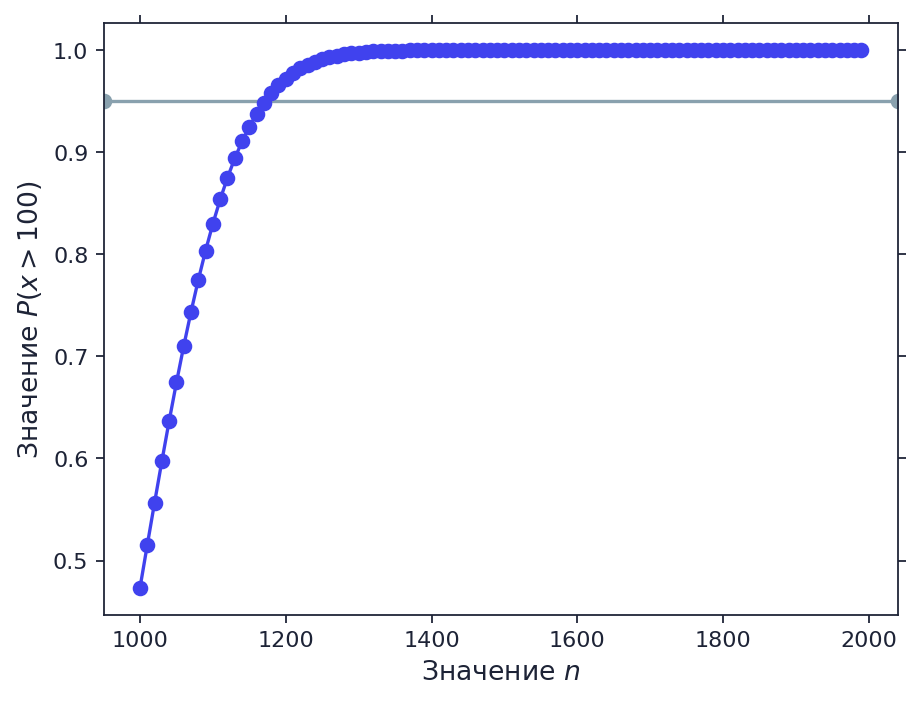

In [35]:
N = np.arange(1000, 2000, 10)
probs = []

for n in N:
    probs.append(1 - st.binom.cdf(100, n, 0.1))

plt.axhline(y=0.95, linestyle='-', color='#89A1AE')
plt.plot(N, probs)
plt.xlabel('Значение $n$')
plt.ylabel('Значение $P(x>100)$')
plt.show()

Из графика видно, что искомая вероятность 0.95 соответствует некоторому $n \approx 1 \, 170$; найдем это $n$:

In [36]:
N = np.arange(1165, 1175, 1)
probs = dict()

for n in N:
    probs[n] = round(1 - st.binom.cdf(100, n, 0.1), 3)

probs

{1165: 0.943,
 1166: 0.944,
 1167: 0.945,
 1168: 0.946,
 1169: 0.947,
 1170: 0.948,
 1171: 0.949,
 1172: 0.95,
 1173: 0.951,
 1174: 0.952}

Таким образом, искомый параметр n=1 172. Построим PMF распределения для диапазона $[0, \, 200]$:

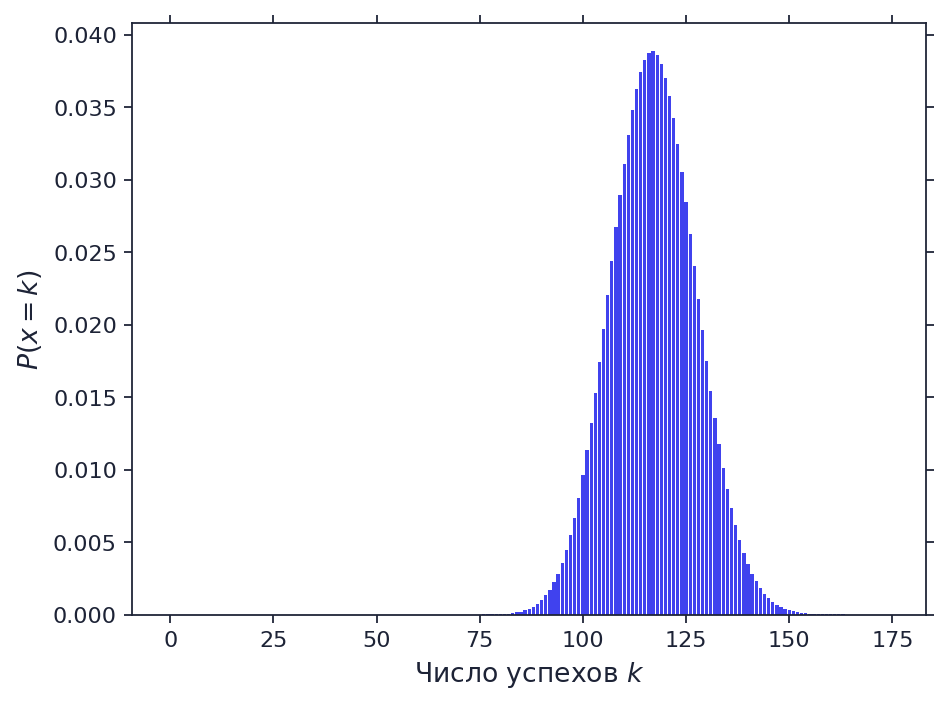

In [37]:
distr = st.binom(n=1172, p=0.1)
x = np.arange(0, 175, 1)

plt.bar(x, distr.pmf(x))
plt.xlabel('Число успехов $k$')
plt.ylabel('$P(x=k)$')
plt.show()

**Вывод:** Искомое значение минимального числа промокодов, которые необходимо разослать, чтобы с вероятностью 0.95 как минимум 100 клиентов продлили подписку, равно $n=1 \, 172$

### 7.2. Вероятность открытия уведомлений
<a class="anchor" id="7.2"></a>

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 
1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

Клиенты могут открыть уведомление, а могут не открывать: таким образом, в данном случае имеем дело с биномиальным распределением с параметрами $n=1 \, 000 \, 000, \ p=0.4$.

Воспользуемся нормальной аппроксимацией биномиального распеделения: в данном случае такая аппроксимация правомерна, т. к. в данном случае $\mu=np=400 \, 000, \ \sigma=\sqrt{np(1-p)}=490$ и промежуток $\mu \pm 3\sigma$, т. е. $400 \,000 \pm 1 \, 470 $ лежит в пределах $[0, \, 1 \, 000 \, 000]$.

Построим PDF распределения:

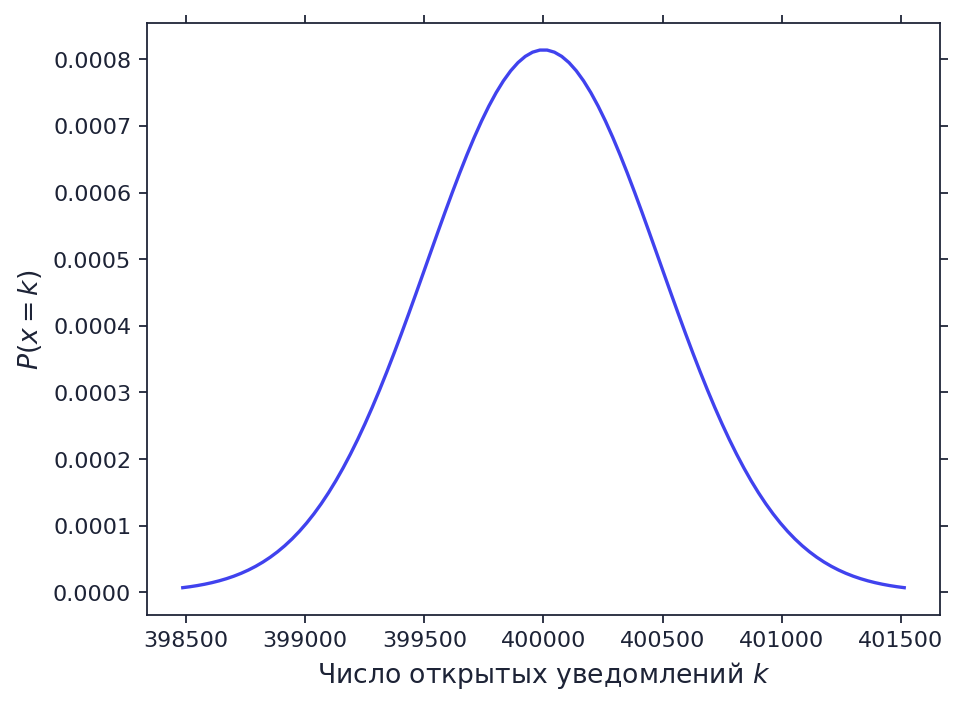

In [38]:
mu = 400000
sigma = 240000
distr = st.norm(400000, 490)

x = np.linspace(distr.ppf(0.001), distr.ppf(0.999), 100)
plt.plot(x, distr.pdf(x), '-')
plt.xlabel('Число открытых уведомлений $k$')
plt.ylabel('$P(x=k)$')
plt.show()

С поомщью аппроксимации оценим вероятность того, что уведомление откроют не более 399 500 пользователей, т. е. $P(x \le 399 \, 500)=F(399 \, 500)$:

In [39]:
print(f'P(x < 399 500) = {round(distr.cdf(399500), 3)}')

P(x < 399 500) = 0.154


**Вывод:** С помощью аппроксимации биномиального распределения нормальным, был построен график PDF для распределения числа открытых уведомлений, а также найдена вероятность того, что уведомление откроют не более 399 500 пользователей: $P(x \le 399 \, 500)=0.15$

## 8. Выводы
<a class="anchor" id="8"></a>

В проекте использовались данные сервиса аренды самокатов GoFast: данные содержат информацию о 1534 пользователях из восьми городов, а также об их поездках (18 068 наблюдений).

В ходе проведения предобработки данных была произведена работа по приведению данных к необходимому типу, а также по удалению дубликотов. 

В ходе проведения исследовательского анализа данных, были получены следующие выводы:
1. В данных представлены 8 городов; наибольшее число поездок — в Пятигорске (219), наименьшее — в Москве (168, т. е. на 23.3% меньше);
2. Число пользователей без подписки — 835 (54.4% выборки); число пользователей с подпиской — 699 (45.6% выборки, т. е. на 16.3% меньше);
3. Возраст пользователей варьируется от 12 до 43 лет и имеет распределение, близкое к нормальному, со средним $\bar{x}^{\text{age}}=24.9$ и стандартным отклонением $\text{sd}^{\text{age}}=4.57$;
4. Расстояние, которое пользователь преодолел за одну поездку, варьируется от 0.9 до 7 211 м и является бимодальным, данные можно разделить на две группы, распределение в каждой из которых близко к нормальному:
      * короткие поездки: 0 ... 1 500 м с модой 800 м (около 10% всех поездок)
      * длинные поездки: более 1500 м с модой 3 200 м (около 90% всех поездок)     
Вероятно, наличие коротких поездок связано с тем, что новым пользователям интересно "попробовать" покататься;
6. Продолжительность поездок варьируется от 30 сек до 40.8 мин и имеет распределение, близкое к нормальному, со средним $\bar{x}^{d}=17.8$ и стандартным отклонением $\text{sd}^{d}=6.1$;  
   Аномалия из 95 поездок длительностью 30 сек (свойственная только для пользователей без подписки), судя по расстоянию этих поездок, появилась из-за ошибки и была удалена.

Данные о пользователях и их поездах были объединыне в общий датафрейм `df`, на основе которого были также созданы датафреймы `df_free` и `df_ultra` с информацией о пользователях без подписки и с подпиской соовтеттвенно. Были получены следующие выводы:
1. Относительно распределений расстояния поездки:
   * Выборки отличаются средним и медианой: для пользователей с подпиской $\bar{x}^d_1=3 \, 115, \ \text{me}^d_1=3 \, 148$, а для пользователей без подписки эти значения меньше и составляют $\bar{x}^d_0=3 \, 045, \ \text{me}^d_0=3 \, 115$;
   * Данные для пользователей с подпиской менее вариативны ($\text{sd}^d_1=836.9$), чем для пользователей без подписки ($\text{sd}^d_0=1246.2$)
2. Относительно распределения продолжительности поездки:
   * Распределения для обеих групп пользователей близки к нормальному, однако в среднем длительность поездки для пользователей с подпиской (со средним и медианой $\bar{x}^t_1=18.5, \ \text{me}^t_1=18.2$) больше, чем для пользователей без подписки (со средним и медианой $\bar{x}^t_0=17.4, \ \text{me}^t_0=17.3$)
  
Был создан датафрейм `df_agg` с аггрегированными данными о поездах; было расчитано, что пользователи с подпиской (со средним и медианой $\bar{x}_1^\$=362.8, \ \text{me}_1^\$=337 $), в среднем, приносят компании на 10% больший доход, чем пользователи без подписки (со средним и медианой $\bar{x}_0^\$=328.6, \ \text{me}_0^\$=274 $).

Были проверены некоторые статистические гипотезы:
1. Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что средняя продолжительность поездки среди пользователей с подпиской больше, чем среди пользователей без подписки со значением p-value $1.28 \cdot 10^{-34}$;
2. Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что действительно можно сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3 130 м;
3. Результаты правостороннего t-теста со значением уровня статистической значимости $\alpha=0.05$ показали, что средняя помесячная выруска от пользователей с подпиской больше, чем от пользователей без подписки со значением p-value $8.87 \cdot 10^{-40}$;
4. Если бы пришлось проверять статистическую гипотезу для двух выборок из одних и тех же пользователей до и после некоторого события, необходимо было бы применить t-тест для зависимых выборок `st.ttest_rel`.

Были решены задачи, связанные с построением биномиальных распределений:
1. Минимальное число промокодов, которые необходимо разослать, чтобы с вероятностью 0.95 как минимум 100 клиентов продлили подписку, равно $n=1 \, 172$;
2. С помощью аппроксимации биномиального распределения нормальным, был построен график PDF для распределения числа открытых уведомлений, а также найдена вероятность того, что уведомление откроют не более 399 500 пользователей: $P(x \le 399 \, 500)=0.15$.